In [1]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
sns.set()
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [3]:
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
lemmatizer = WordNetLemmatizer()

In [5]:
categories= ['misc.forsale', 'sci.electronics', 'talk.religion.misc']

In [7]:
news_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42, download_if_missing=True)

In [9]:
news_data_df = pd.DataFrame({'text' : news_data['data'], 'category': news_data.target})

In [11]:
news_data_df['cleaned_text'] = news_data_df['text'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x))) if word.lower() not in stop_words]))

In [12]:
tfidf_model = TfidfVectorizer(max_features=200)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(news_data_df['cleaned_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,00,10,100,12,14,15,16,20,25,30,...,well,wire,wiring,without,word,work,world,would,writes,year
0,0.439108,0.0,0.000000,0.0,0.000000,0.128788,0.137895,0.128562,0.134368,0.0,...,0.0,0.0,0.0,0.0,0.0,0.113938,0.000000,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.294937,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.142267,0.106317,0.100306,0.0
4,0.000000,0.0,0.207003,0.0,0.191897,0.182138,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [15]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tfidf_df)
y_kmeans = kmeans.predict(tfidf_df)
news_data_df['obtained_clusters'] = y_kmeans

In [17]:
pd.crosstab(news_data_df['category'].replace({0:'misc.forsale', 1:'sci.electronics', 2:'talk.religion.misc'}),\
            news_data_df['obtained_clusters'].replace({0 : 'cluster_1', 1 : 'cluster_2', 2 : 'cluster_3', 3: 'cluster_4'}))

obtained_clusters,cluster_1,cluster_2,cluster_3,cluster_4
category,,,,
misc.forsale,320,96,168,1
sci.electronics,9,451,131,0
talk.religion.misc,0,74,67,236


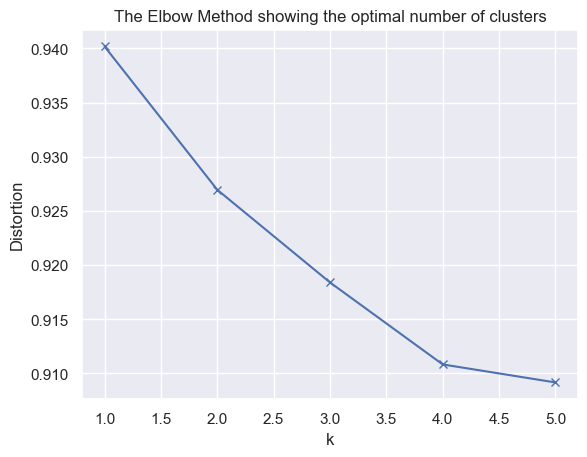

In [19]:
distortions = []
K = range(1,6)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_df)
    distortions.append(sum(np.min(cdist(tfidf_df, kmeanModel.cluster_centers_, 'euclidean'), \
                                  axis=1)) / tfidf_df.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()